<a href="https://colab.research.google.com/github/alexandre-bismuth/UncertaintyInDeepLearning/blob/main/UDL_Practical_2_A_Toolkit_for_the_Probabilistic_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UDL Practical 2 - A Toolkit for the Probabilistic Machine Learner

🚀 Welcome to practical 2!

In this notebook we'll explore practical tools for probabilistic modeling and learn how to use them in deep learning. We'll get into the nuts and bolts of:
- 🔍 Kullback-Leibler (KL) Divergence
- 🧮 Importance Sampling for MC integration
- 🤖 Variational Autoencoders and differentiating through MC estimators

Let's dive in! 🌊


In [1]:
# Install required packages by uncommenting the following line
# !pip install tqdm numpy matplotlib torch torchvision

# Setup
import tqdm                     # for progress bars (most important DL library!)
import numpy as np              # for numerical operations
import matplotlib.pyplot as plt # for plotting
import torch                    # For deep learning
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Part 1: Kullback-Leibler (KL) Divergence

In many machine learning tasks, we want to approximate (learn) a target distribution $p(\mathbf{x})$ using a model distribution $q_\theta(\mathbf{x})$. To use optimization techniques and find the best model distribution, we need a measure of distance between the model and target distributions top optimize for. One such measure is the Kullback-Leibler (KL) divergence, which we'll explore in the following section.

Recall that the Kullback-Leibler (KL) divergence is a measure of distance between two probability distributions. For two distributions $P$ and $Q$,
$$
    \mathrm{KL}(P\|Q) = \mathbb{E}_{\mathbf{X} \sim P} \left(\log\left(\frac{P(\mathbf{X})}{Q(\mathbf{X})}\right)\right).
$$



### KL Divergence as a measure of coding efficiency

For discrete distributions, the KL divergence can be interpreted in terms of optimal coding theory. If we use a coding scheme that is optimized for distribution $Q$ to encode data that actually comes from distribution $P$, we will need on average $\mathrm{KL}(P\|Q)$ extra bits on average compared to using the optimal code for $P$. The average length of a code word for a sample from the distribution can be interpreted as the number of bits need to encode it. So, the KL divergence can be interpreted as the number of extra bits needed to encode a sample from $P$ using a code optimized for $Q$.

**Q1**: The following code builds and optimal prefix code $^*$ for two distributions $P$ and $Q$; use it to estimate the KL divergence between $P$ and $Q$.

$^*$ The theoretical lower bound of the average code length for samples from $P$ is the entropy $H(P)$. In the following we approximate the optimal code with the [Huffman code](https://en.wikipedia.org/wiki/Huffman_coding), which is the optimal prefix code, but in general can have expected length up to $H(P) + 1$ bits.

In [2]:
import math
from collections import Counter
import heapq

# Set random seed for reproducibility
np.random.seed(1)

def build_huffman_tree(freq_dict):
    """Build a Huffman tree from frequency dictionary"""
    heap = [[weight, [char, ""]] for char, weight in freq_dict.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return heap[0][1:]

def get_huffman_codes(tree):
    """Convert Huffman tree to code dictionary"""
    return {char: code for char, code in tree}

events = ['A', 'B', 'C', 'D']
p_probs = [0.4, 0.3, 0.2, 0.1]  # True distribution
q_probs = [0.25, 0.25, 0.25, 0.25]  # Assumed uniform distribution

# Generate sample data from distribution P
n_samples = 50
data = np.random.choice(events, size=n_samples, p=p_probs)

# Calculate empirical frequencies
freq = Counter(data)
empirical_p = {e: freq[e]/n_samples for e in events}

# Build Huffman codes for both distributions
p_freq = {e: p for e, p in zip(events, p_probs)}
q_freq = {e: p for e, p in zip(events, q_probs)}

p_tree = build_huffman_tree(p_freq)
q_tree = build_huffman_tree(q_freq)

p_codes = get_huffman_codes(p_tree)
q_codes = get_huffman_codes(q_tree)

# Actually encode the data using both coding schemes
p_encoded = ''.join(p_codes[symbol] for symbol in data)
q_encoded = ''.join(q_codes[symbol] for symbol in data)

# TODO: Estimate the KL divergence using the difference in average code length
kl_estimate = 0.0
p_total_length = len(p_encoded)
q_total_length = len(q_encoded)

p_avg_length = p_total_length / len(data)
q_avg_length = q_total_length / len(data)
kl_estimate = q_avg_length - p_avg_length

# Calculate KL divergence
kl_div = sum(p_probs[i] * math.log2(p_probs[i]/q_probs[i]) for i in range(len(events)))

print(f"Sample of first 20 symbols: {' '.join(data[:20])}")
print(f"\nEncoding using P's Huffman codes:")
print(f"Codes: {p_codes}")
print(f"Encoded sequence: {p_encoded}")
print(f"\nEncoding using Q's Huffman codes:")
print(f"Codes: {q_codes}")
print(f"Encoded sequence: {q_encoded}")

print(f"\nTotal encoding length using P's codes: {p_total_length} bits")
print(f"Total encoding length using Q's codes: {q_total_length} bits")
print(f"Average bits per symbol using P's codes: {p_avg_length:.3f}")
print(f"Average bits per symbol using Q's codes: {q_avg_length:.3f}")
print(f"Empirical difference in average code length: {kl_estimate:.3f} bits")
print(f"Theoretical KL(P||Q): {kl_div:.3f} bits")

Sample of first 20 symbols: B C A A A A A A A B B B A C A B B B A A

Encoding using P's Huffman codes:
Codes: {'A': '0', 'B': '10', 'D': '110', 'C': '111'}
Encoded sequence: 1011100000001010100111010101000111110010111111000111010110101001011101111101110111010110000

Encoding using Q's Huffman codes:
Codes: {'A': '00', 'B': '01', 'C': '10', 'D': '11'}
Encoded sequence: 0110000000000000000101010010000101010000101100011010000000100001110101000110001011100010000111000000

Total encoding length using P's codes: 91 bits
Total encoding length using Q's codes: 100 bits
Average bits per symbol using P's codes: 1.820
Average bits per symbol using Q's codes: 2.000
Empirical difference in average code length: 0.180 bits
Theoretical KL(P||Q): 0.154 bits


### KL Divergence Between Normal Distributions



**Q2**: For normal distributions $p(x) = \mathbf{N}(x; \mu_1, \sigma_1)$ and $q(x) = \mathbf{N}(x; \mu_2, \sigma_2)$ the KL divergence takes a closed-form expression.

1. Derive it.
2. What happens when $\sigma_1 \to \infty$? when $\sigma_2 \to \infty$?
3. What are the rates of convergence?

**Answer**:
We know that $P(x)=\frac{1}{\sigma_1 \sqrt{2\pi}} e^{-\frac{(x-\mu_1)^2}{2\sigma_1^2}}$ and $Q(x)=\frac{1}{\sigma_2 \sqrt{2\pi}} e^{-\frac{(x-\mu_2)^2}{2\sigma_2^2}}$. We thus get that
$$\frac{P(x)}{Q(x)} = \frac{\sigma_2 \sqrt{2\pi}}{\sigma_1 \sqrt{2\pi}} e^{-\frac{(x-\mu_1)^2}{2\sigma_1^2} + \frac{(x-\mu_2)^2}{2\sigma_2^2}} = \frac{\sigma_2}{\sigma_1} e^{-\frac{(x-\mu_1)^2}{2\sigma_1^2} + \frac{(x-\mu_2)^2}{2\sigma_2^2}}$$

Now we can then take the logarithm of that expression and get:
$$\ln \frac{\sigma_2}{\sigma_1} - \frac{(x-\mu_1)^2}{2\sigma_1^2} + \frac{(x-\mu_2)^2}{2\sigma_2^2}$$

The Kullback–Leibler divergence is the expectation of this log-ratio under $p(x)$:
$$
\mathrm{KL}(p\|q)
= \mathbb{E}_p\left[\ln \frac{P(x)}{Q(x)}\right]
= \ln \frac{\sigma_2}{\sigma_1}
  - \frac{1}{2\sigma_1^2}\mathbb{E}_p[(x-\mu_1)^2]
  + \frac{1}{2\sigma_2^2}\mathbb{E}_p[(x-\mu_2)^2].
$$

From the definition of variance, we know that
$\mathbb{E}_p[(x-\mu_1)^2] = \sigma_1^2$.

Futhermore, we can also get from linearity that
$$
\mathbb{E}_p[(x-\mu_2)^2]
= \mathbb{E}_p[(x-\mu_1 + \mu_1 - \mu_2)^2]
= \sigma_1^2 + (\mu_1 - \mu_2)^2.
$$

Putting it all together we get:
$$
KL(p||q) = \ln \frac{\sigma_2}{\sigma_1}
  - \frac{\sigma_1^2}{2\sigma_1^2}
  + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2} \\
= \ln \frac{\sigma_2}{\sigma_1}
  + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2}
  - \frac{1}{2}.
$$

which is a closed-form expression for the KL divergence.

----

When we have $\sigma_1 \to \infty$, we get that the ln term goes to 0 and the middle fraction goes to infinity.

When we have $\sigma_2 \to \infty$, the ln term goes to infinity and the middle fraction to 0.

In any case, the KL divergence diverge when $\sigma_1 \to \infty$ or $\sigma_2 \to \infty$.

----

When we have $\sigma_1 \to \infty$, the term that goes to infinity grows quadratically. It is thus a quadratic rate of convergence.

When we have $\sigma_2 \to \infty$, the term that goes to infinity grows logarithmically. It is thus a logarithmic rate of convergence.

----

**Q3**: Using the formula you derived, plot the KL divergence between two normal distributions for different values of $\mu_1, \mu_2, \sigma_1, \sigma_2$.

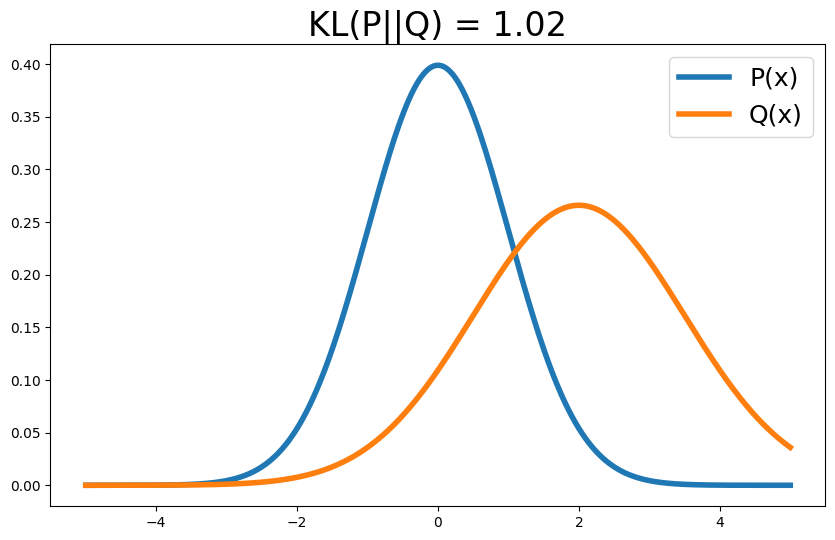

In [13]:
def kl_normal(mu1, sigma1, mu2, sigma2):
    # TODO: Implement the KL divergence between two normal distributions
    return np.log(sigma2/sigma1) + (sigma1**2 + (mu1-mu2)**2)/(2*sigma2**2) - 0.5

# Plot different distributions to build intuition
mu1, sigma1 = 0, 1 # TODO: Change these values
mu2, sigma2 = 2, 1.5 # TODO: Change these values

x = np.linspace(-5, 5, 1000)
p = 1/(sigma1*np.sqrt(2*np.pi))*np.exp(-(x-mu1)**2/(2*sigma1**2))
q = 1/(sigma2*np.sqrt(2*np.pi))*np.exp(-(x-mu2)**2/(2*sigma2**2))

plt.figure(figsize=(10,6))
plt.plot(x, p, label='P(x)', linewidth=4)
plt.plot(x, q, label='Q(x)', linewidth=4)
plt.title(f'KL(P||Q) = {kl_normal(mu1,sigma1,mu2,sigma2):.2f}', fontsize=24)
plt.legend(fontsize=18)
plt.show()

### Forward vs. Reverse KL; Mode Seeking vs. Mode Covering

When approximating a fixed distribution $p(\mathbf{x})$ with a variational distribution $q_\theta(\mathbf{x})$ via KL minimization, we get different behaviors depending on the "direction" of the KL loss:

1. **Forward KL**: Optimizing for $\mathrm{argmin}_\theta \mathrm{KL}(p(\mathbf{x} \| q_\theta(\mathbf{x}))$ forces $q_\theta(\mathbf{x})$ to include all areas for which $p(\mathbf{x})$ assigns non-zero mass, resulting in mode covering behavior.

2. **Reverse KL:** Optimizing for  $\mathrm{argmin}_\theta \mathrm{KL}(q_\theta(\mathbf{x}) \| p(\mathbf{x}))$ forces $q_\theta(\mathbf{x})$ to exclude all the areas for which $p(\mathbf{x})$ assigns zero mass, resulting in mode seeking behavior with $q_\theta(\mathbf{x})$ assigning mass to few parts of the space, near $p(\mathbf{x})$'s modes.

**Q4**: In the following code we fit parametrix gaussian distribution to a bimodal distribution using both forward and reverse KL.
1. What does `alpha` represent in the code bellow?
2. Implement forward and reverse KL estimators (*tip*: use damping of 1e-10 when computing logs).
3. Play around with the code, what is the threshold for $\alpha$ that makes the reverse KL mode seeking?


In [ ]:
alpha = 4.8

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a bimodal target distribution p(x)
def p(x):
    # Mixture of two Gaussians
    dist1 = torch.distributions.Normal(loc=torch.tensor([0.0]).to(device), scale=torch.tensor([1.0]).to(device))
    dist2 = torch.distributions.Normal(loc=torch.tensor([alpha]).to(device), scale=torch.tensor([1.0]).to(device))
    return 0.5 * np.exp(dist1.log_prob(x)) + 0.5 * np.exp(dist2.log_prob(x))

# Define a variational distribution q(x) with learnable parameters
class VariationalDist:
    def __init__(self, mu, var):
        self.mu = nn.Parameter(torch.tensor([mu]).to(device))
        self.logvar = nn.Parameter(torch.tensor([0.5 * np.log(var)]).to(device))

    def pdf(self, x):
        dist = torch.distributions.Normal(self.mu, torch.exp(0.5 * self.logvar))
        return torch.exp(dist.log_prob(x))

# Initialize distributions and optimizer with mean between the two modes and variance 1
q_forward = VariationalDist(0.5 * alpha, 1.0)
opt_forward = torch.optim.Adam([q_forward.mu, q_forward.logvar], lr=0.01)

q_reverse = VariationalDist(0.5 * alpha, 1.0)
opt_reverse = torch.optim.Adam([q_reverse.mu, q_reverse.logvar], lr=0.01)

# Uniformally spaced points for sum approximation
x = torch.linspace(-5, 20, 100000).to(device)

# Probabilities on the estimation points
p_x = p(x)

for i in tqdm.trange(1000):
    # Estimate forward KL
    q_forward_x = q_forward.pdf(x)
    forward_kl = 0.0 # TODO: Implement forward KL estimator

    # Optimize for forward KL
    opt_forward.zero_grad()
    forward_kl.backward()
    opt_forward.step()

    # Estimate reverse KL
    q_reverse_x = q_reverse.pdf(x)
    reverse_kl = 0.0 # TODO: Implement reverse KL estimator

    # Optimize for reverse KL
    opt_reverse.zero_grad()
    reverse_kl.backward()
    opt_reverse.step()

# Plot results
x = torch.linspace(-5, alpha + 5, 5000).to(device)
p_x = p(x)

plt.figure(figsize=(10, 5))

# Forward KL result
plt.subplot(121)
plt.plot(x.cpu().detach().numpy(), p_x.cpu().detach().numpy(), 'k-', lw=3, label='p(x)')
plt.plot(x.cpu().detach().numpy(), q_forward.pdf(x).cpu().detach().numpy(), 'r--', lw=2, label='q(x)')
plt.title(f'Forward KL\nμ={q_forward.mu.item():.2f}, σ={np.exp(0.5 * q_forward.logvar.item()):.2f}', fontsize=18)
plt.legend(fontsize=14)
plt.xlabel('x', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Reverse KL result
plt.subplot(122)
plt.plot(x.cpu().detach().numpy(), p_x.cpu().detach().numpy(), 'k-', lw=3, label='p(x)')
plt.plot(x.cpu().detach().numpy(), q_reverse.pdf(x).cpu().detach().numpy(), 'b--', lw=2, label='q(x)')
plt.title(f'Reverse KL\nμ={q_reverse.mu.item():.2f}, σ={np.exp(0.5 * q_reverse.logvar.item()):.2f}', fontsize=18)
plt.legend(fontsize=14)
plt.xlabel('x', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

## Part 2: Importance sampling

As we saw in the last practical, Monte Carlo sampling is a powerful technique for estimating expectations. However, it often fails in practice due to three key issues:
1. The variance of MC estimates can be too high, requiring a large number of samples
2. Sometimes we can't sample from the target distribution directly (e.g. due to unknown normalization)
3. MC sampling is inefficient for estimating quantities depending on rare events as most samples are wasted on irrelevant regions

Importance sampling addresses these issues by allowing us sample from a differen distribution. By properly reweighting the samples, we still get an [unbiased estimator](https://en.wikipedia.org/wiki/Bias_of_an_estimator), but possibly achieve lower variance.

More concretly, let $\mathbf{x}$ be a random variable with distribution $p$ and let $f(\mathbf{x})$ be a function of $\mathbf{x}$. In MC integration we want to estimate the expectation $\boldsymbol{\mu}_f = \mathbb{E}_{p}(f(\mathbf{x}))$ using $N$ independent samples from $\mathbf{x}_1, \dots, \mathbf{x}_N \sim p$, resulting in the following estimator:

$$
\hat{\boldsymbol{\mu}}_f = \frac{1}{N}\sum_{i=1}^N f(\mathbf{x}_i)
$$

Note that we can think of $\hat{\boldsymbol{\mu}}_f$ as a random variable itself (as a function of the samples $\mathbf{x}_1, \dots, \mathbf{x}_N$).

**Q5**: Prove that $\hat{\boldsymbol{\mu}}_f$ is an unbiased estimator of $\boldsymbol{\mu}_f$, i.e. that $\mathbb{E}_{p}(\hat{\boldsymbol{\mu}}_f) = \boldsymbol{\mu}_f$.

**Answer**: From linearity of the expectation and the fact that $\boldsymbol{\mu}_f = \mathbb{E}_{p}(f(\mathbf{x}))$ by definition:
$$\mathbb{E}_{p}(\hat{\boldsymbol{\mu}}_f) = \mathbb{E}_{p}\left(\frac{1}{N}\sum_{i=1}^N f(\mathbf{x}_i) \right)  = \frac{1}{N}\sum_{i=1}^N  \mathbb{E}_{p}\left(f(\mathbf{x}_i) \right)  = \frac{1}{N}\sum_{i=1}^N  \boldsymbol{\mu}_f  = \boldsymbol{\mu}_f$$

----

**Q6**: What is the variance of $\hat{\mathbb{E}}_{p}(f(\mathbf{x}))$?

**Answer**: Since $\boldsymbol{\mu}_f = \mathbb{E}_{p}(f(\mathbf{x}))$, we can say the following:
$$\mathrm{Var}(\hat{\mathbb{E}}_{p}(f(\mathbf{x})) = \mathrm{Var}(\hat{\boldsymbol{\mu}_f}) = \mathrm{Var} \left( \frac{1}{N}\sum_{i=1}^N f(\mathbf{x}_i) \right)$$

Since variance is additive for independent variable and that $\mathrm{Var}(ax+b) = a^2\mathrm{Var(X)}$, we get that
$$\mathrm{Var}(\hat{\mathbb{E}}_{p}(f(\mathbf{x})) = \frac{1}{N^2} \sum_{i=1}^N \mathrm{Var}(f(x_i)) = \frac{1}{N^2} \times N \times \mathrm{Var}(f(x)) = \frac{\mathrm{Var}(f(x))}{N}$$

This expression can be simplified further using the definition of variance as
$$\mathrm{Var}(\hat{\mathbb{E}}_{p}(f(\mathbf{x})) = \frac{1}{N} \left(\mathbb{E}_p(f(x)^2) - \mathbb{E}_p(f(x))^2\right) = \frac{1}{N} \left(\mathbb{E}_p(f(x)^2) - \boldsymbol{\mu_f}^2 \right) $$

----

The question above highlights a key limitation of MC estimators: reducing its variance requires increasing the number of samples. When the initial variance is high, achieving an accurate estimate may require a prohibitively large number of samples, making the computation expensive and potentially impractical.

The idea behind importance sampling is to use samples from a different distribution $q$ (called the proposal distribution) to lower the variance of the estimator $\hat{\boldsymbol{\mu}}_f$ or to get a simpler sampling process. To do so, we need to reweight the samples to account for the difference between $p$ and $q$.

**Q7**: Let $q$ be probability distribution such that $q(\mathbf{x}) > 0$ for all $\mathbf{x}$ with $f(\mathbf{x})p(\mathbf{x}) \neq 0$. Prove that

$$
\boldsymbol{\mu}_f = \mathbb{E}_{q}\left(w(\mathbf{x})f(\mathbf{x})\right)
$$

where $w(\mathbf{x}) = \frac{p(\mathbf{x})}{q(\mathbf{x})}$ is called the importance weight.

**Answer**:

$$\mathbb{E}_{q}\left(w(\mathbf{x})f(\mathbf{x})\right) = \mathbb{E}_{q}\left(\frac{p(\mathbf{x})f(\mathbf{x})}{q(\mathbf{x})}\right) = \int_{-\infty}^{\infty} \frac{p(\mathbf{x})f(\mathbf{x})}{q(\mathbf{x})} q(\mathbf{x}) = \int_{-\infty}^{\infty} p(\mathbf{x})f(\mathbf{x}) = \mathbb{E}_p(f(\mathbf{x})) = \boldsymbol{\mu}_f
$$

---

We can now form a new unbiased estimator using the samples $\mathbf{x}_1, \dots, \mathbf{x}_N$ from $q$:

$$
\hat{\boldsymbol{\mu}}_{f, q} = \frac{1}{N}\sum_{i=1}^N w(\mathbf{x}_i)f(\mathbf{x}_i)
$$

**Q8**:
1. What properties should we make for a good proposal distribution $q$?

We should make our proposal distribution always strictly positive with quite a large margin from 0 to avoid having samples that will agressively skew the distribution. We also would like q to resemble the product $p \times f$, to avoid having a high variance in weights that would skew the sum.

2. *Bonus:* What is the variance of $\hat{\boldsymbol{\mu}}_{f, q}$? What is the theoretically optimal proposal distribution $q(\mathbf{x})$ that achieces the lowest variance?

**Q9**: Let
- $p(\mathbf{x}) = \mathbf{N}(\mathbf{x}; 1, 1)$
- $f(\mathbf{x}) = 10 \cdot \exp \left(-5 (\mathbf{x} - 3)^4 \right)$


Run the following to get a plot of $f(\mathbf{x})$.

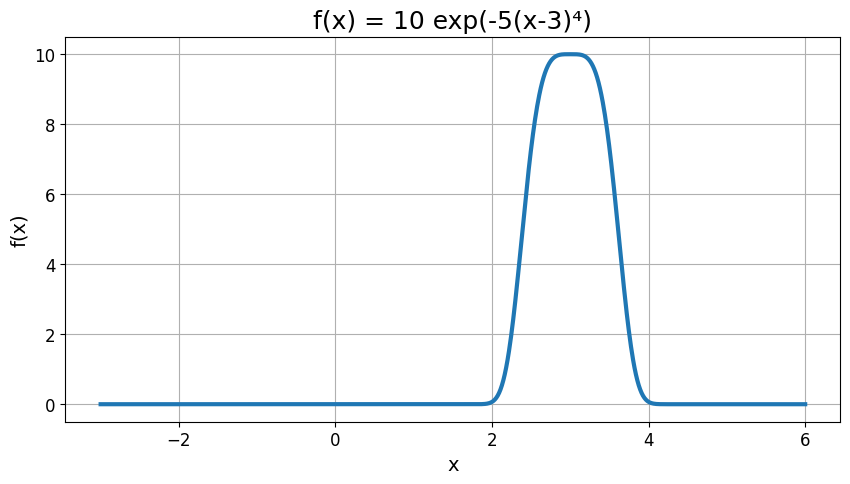

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-3, 6, 1000)
f = 10 * np.exp(-5 * (x - 3)**4)
plt.figure(figsize=(10, 5))
plt.plot(x, f, lw=3)
plt.grid(True)
plt.xlabel('x', fontsize=14)
plt.ylabel('f(x)', fontsize=14)
plt.title('f(x) = 10 exp(-5(x-3)⁴)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


1. What is a good proposal distribution $q$ for this task?

We can see from the plot that the product $p \times f$ will be 0 anywhere except from 2 to 4 with a sort of pseudo-normal distributon. However, since p(x) is a normal distribution with mean 1 and standard deviation 1, it will give more importance to the values closer to 2.

From a first look, we can therefore believe that a simple exponential distribution $q(x) = e^{-x+2.5}$ for $x > 0$ and $q(x) = 0$ otherwise could be a good proposal distribution.

---

2. Compute $w(\mathbf{x})$ for $p(\mathbf{x}) = \mathbf{N}(\mathbf{x}; 0, 1)$ and $q(\mathbf{x}) = \mathbf{N}(\mathbf{x}; 3, 1)$.

We know from question 2 that $$\frac{p(x)}{q(x)} = \frac{\sigma_2}{\sigma_1} e^{-\frac{(x-\mu_1)^2}{2\sigma_1^2} + \frac{(x-\mu_2)^2}{2\sigma_2^2}}$$

Applying this result with our values gives:

$$\frac{p(x)}{q(x)} = e^{-\frac{x^2}{2} + \frac{(x-3)^2}{2}} = e^{\frac{-x^2 + x^2 - 6x + 9}{2}} = e^{\frac{-6x + 9}{2}} = e^{-3x + 4.5}$$


3. Implement importance sampling to estimate $\mathbb{E}_{p}[f(\mathbf{x})]$.

In [4]:
n_samples = 100 # Number of Monte Carlo samples

# Standard Monte Carlo
x = np.random.randn(n_samples, 1)
f_x = 10 * np.exp(-5 * (x - 3) ** 4)
MC = np.mean(f_x)
print(f"Standard MC estimate for E_p[g(x)]: {MC}")

# Importance sampling
y = 3 + np.random.randn(n_samples, 1);
f_y = 10 * np.exp(-5 * (y  - 3) ** 4);

# TODO: your code here, compute `f_weighted`
f_weighted = f_y * np.exp(-3*y+4.5)

IS = np.mean(f_weighted)
print(f"Importance-sampling MC estimate for E_p[g(x)]: {IS}")

Standard MC estimate for E_p[g(x)]: 0.09821599164389933
Importance-sampling MC estimate for E_p[g(x)]: 0.09914617827400793


## Part 3: Differentiating Through MC Estimators

In machine learning, we often need to optimize objectives that involve expectations over random variables. For example:
- In variational inference, we minimize $\mathbb{E}_{\mathbf{Z} \sim q_\theta}(\log q_\theta(\mathbf{Z}) - \log p(\mathbf{X},\mathbf{Z}))$
- In reinforcement learning, we maximize $\mathbb{E}_{\pi_\theta(a|s)}(R(s,a))$
- In generative modeling, we maximize $\mathbb{E}_{p_\theta(x)}(\log p_\theta(x))$

These expectations are typically estimated using Monte Carlo sampling since the integrals are often intractable. For example, we might estimate:
$\mathbb{E}_{q_\theta(z)}(\log q_\theta(z) - \log p(x,z)) \approx \frac{1}{N}\sum_{i=1}^N (\log q_\theta(z_i) - \log p(x,z_i))$
where $z_i \sim q_\theta(z)$

However, differentiating through these MC estimates is challenging because:
1. The sampling operation itself is not differentiable
2. The sampling distribution parameters (θ) that we want to optimize appear in both the sampling process and function evaluation




### Reparametrization Trick
The reparametrization trick is a technique for efficiently computing gradients through Monte Carlo estimators. It allows us to differentiate through the sampling process, which is crucial for training deep neural networks.

Let $\mathbf{x} \sim p_\theta$ be a random variable with distribution $p_\theta(\mathbf{x})$, such that $\mathbf{x} = g_\theta(\epsilon)$ for some deterministic function $g_\theta$ and some noise $\epsilon \sim q$.

**Q10**: Prove that

$$
\nabla_\theta \mathbb{E}_{p_\theta(\mathbf{x})}(f(\mathbf{x})) = \mathbb{E}_{q(\epsilon)}(\nabla_\theta f(g_\theta(\epsilon)))
$$


#### Variational Autoencoders

Variational Autoencoders (VAEs) are generative models that learn to encode data into a lower-dimensional latent space and decode it back.
They consist of two main components:

1. An encoder network that maps input data x to a probability distribution $q_\phi(\mathbf{z} | \mathbf{x})$ in latent space, parameterized by $\mu(\mathbf{x})$.
2. A decoder network that maps latent vectors $\mathbf{z}$ back to the original data space as $p(\mathbf{x}|\mathbf{z})$.
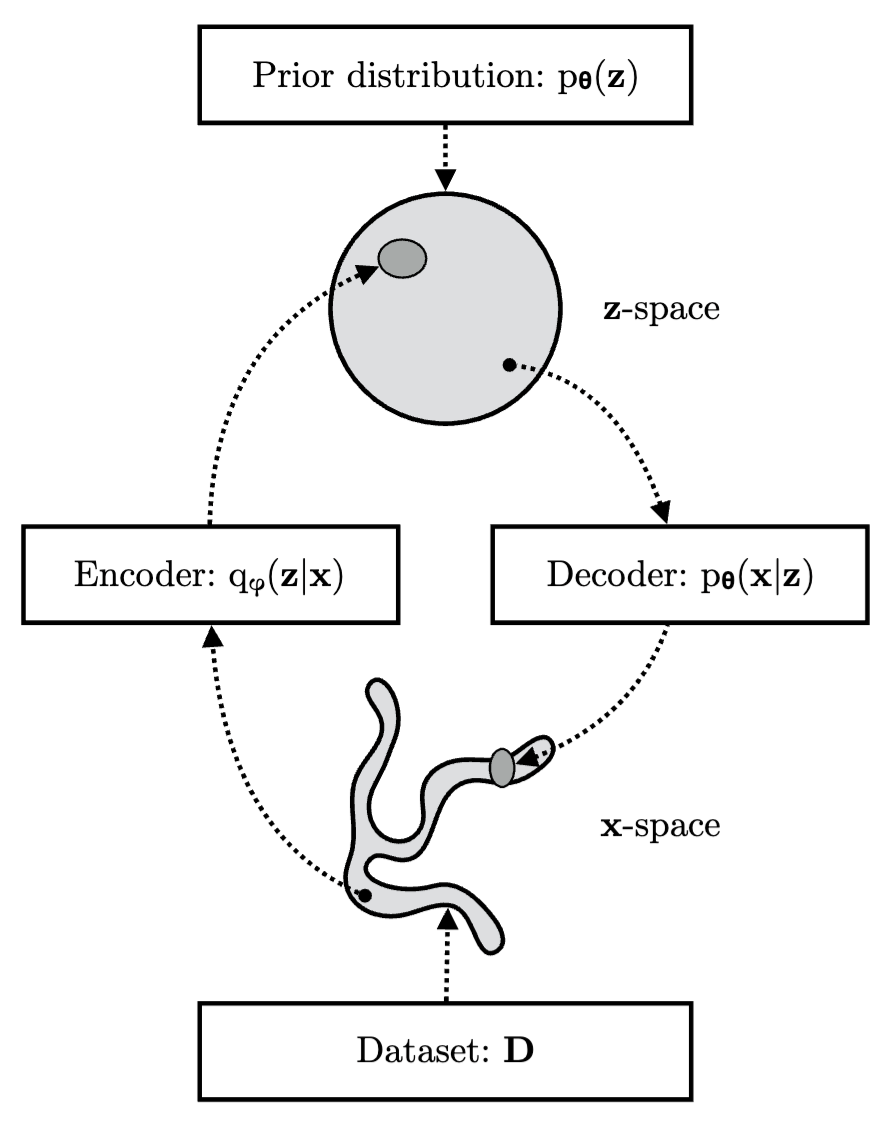
The VAE is trained to minimize two objectives:
- Reconstruction loss: How well the decoder can reconstruct the input from the latent representation
- KL divergence loss: How close the learned latent distribution $q(\mathbf{z}|\mathbf{x})$ is to a prior $p(\mathbf{z})$, usually $\mathbf{N}(0,1)$

The total loss function is:
$$
\mathbf{L}(\theta, \phi) = -\mathbb{E}(\log p_\theta(\mathbf{x}|\mathbf{z})) + \text{KL}(q_\phi(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z}))
$$

However, a key challenge in VAEs is that we need to sample from the latent distribution ($\mathbf{z} \sim \mathbf{N}(\mathbf{z}; \boldsymbol{\mu}, \boldsymbol{\sigma}^2)$) during training, but this sampling operation is not differentiable. This prevents gradients from flowing back to the encoder network that produces $\mu(\mathbf{x})$ and $\sigma(\mathbf{x})$.

The reparameterization trick solves this by reformulating the sampling as $\mathbf{z} = \boldsymbol{\mu} + \boldsymbol{\sigma} * \epsilon$ where $\epsilon \sim \mathbf{N}(0,1)$, separating the random sampling from the distribution parameters. This makes the operation differentiable with respect to $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$, allowing proper training of the encoder.

The training process works as follows:
1. The encoder processes input $\mathbf{x}$ and outputs $\boldsymbol{\mu}(\mathbf{x})$ and $\boldsymbol{\sigma}(\mathbf{x})$
2. A latent vector z is sampled using the reparameterization trick
3. The decoder reconstructs the input from z
4. The loss is computed and backpropagated to update both networks

Below is an implementation of a VAE for MNIST digits. The encoder-decoder process described above is implemented in the `forward` method, with the reparameterization sampling step handled by the `reparameterize` method that connects the encoder and decoder networks.

**Q11**: Implement the `reparameterize` method in the `VAE` class and train the model (don't worry if the loss is high, it should be around ~13,000).

In [ ]:
# Simple VAE for MNIST
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )

        # Mean and log variance layers
        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparametrization trick here
        pass

def train_vae():
    # Load MNIST
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    # Initialize model and optimizer
    model = VAE()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    for epoch in range(20):
        for batch_idx, (data, _) in (pbar := tqdm.tqdm(enumerate(train_loader))):
            optimizer.zero_grad()

            # Encode and decode data
            recon_batch, mu, logvar = model(data)

            # Reconstruction loss
            recon_loss = F.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum')

            # KL divergence loss
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            # Total loss
            loss = recon_loss + kl_loss

            loss.backward()
            optimizer.step()

            pbar.set_description(f'Epoch {epoch + 1}, Batch {batch_idx}, Loss: {loss.item():.4f}')

    return model

model = train_vae()


If you've implemented `reparameterize` correctly, you should be able to sample images from the latent space using the following function.

In [ ]:
def show_samples(model, n=10):
    model.eval()
    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(n, 2)  # 2 is latent dimension

        # Decode the latent vectors
        samples = model.decode(z)

        # Plot generated images
        plt.figure(figsize=(10, 5))
        for i in range(n):
            plt.subplot(2, n//2, i + 1)
            plt.imshow(samples[i].reshape(28, 28).detach(), cmap='gray')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

show_samples(model)

*Bonus:* Way are VAEs better than [standard autoencoders](https://en.wikipedia.org/wiki/Autoencoder#:~:text=An%20autoencoder%20is%20a%20type,data%20from%20the%20encoded%20representation.)?

### REINFORCE (*Bonus*)
The REINFORCE algorithm, also known as the score function estimator or likelihood ratio estimator, is another approach for computing gradients through stochastic operations when it's no easy to express $\mathbf{x}$ as a deterministic function of $\epsilon$. Unlike the reparametrization trick, REINFORCE can handle discrete random variables but typically has higher variance.

**Q12**: Prove that

$$
\nabla_\theta \mathbb{E}_{p_\theta(\mathbf{x})}(f(\mathbf{x})) = \mathbb{E}_{p_\theta(\mathbf{x})}(\nabla_\theta \log p_\theta(\mathbf{x}) f(\mathbf{x}))
$$

*Hint*: What is the gradient of the log-probability of a distribution?

**Q13**: In the following code, we implement a parametric policy $p_\theta(\mathbf{a})$ that assigns a probability distribution to one of three actions $a \in \{0, 1, 2\}$. Each action $a$ has a corresponding reward $R(a)$, in our case $R(1) = +1$ and 0 otherwise. We want to train the policy to maximize the expected reward, i.e.
$$
\mathrm{argmax}_\theta \mathbb{E}_{p_\theta(a)}(R(a)).
$$

Implement REINFORCE to train the policy.


In [ ]:
class DiscretePolicy(nn.Module):
    def __init__(self, probs):
        super().__init__()
        self.logits = nn.Parameter(torch.log(torch.tensor(probs)))

    def forward(self):
        return torch.softmax(self.logits, dim=0)

    def sample(self):
        probs = self.forward()
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action, log_prob

# Try to increase probability of selecting action 1
policy = DiscretePolicy([0.2, 0.2, 0.6])  # Initial probabilities
optimizer = torch.optim.Adam(policy.parameters(), lr=0.004)

for i in (pbar := tqdm.tqdm(range(1000))):
    optimizer.zero_grad()

    # Sample action and get log probability
    action, log_prob = policy.sample()

    # Define reward: +1 if action is 1, else 0
    reward = torch.tensor(1.0 if action == 1 else 0.0)

    # TODO: Implement REINFORCE update

    # Current policy
    probs = policy.forward().detach().numpy()
    pbar.set_description(f"Step {i}, Probabilites: 0: {probs[0]:.4f}, 1: {probs[1]:.4f}, 2: {probs[2]:.4f}")